In [1]:
! pip install -q -U tensorflow-addons
! pip install -q kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.0 MB/s eta 0:00:00


In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download abdallahalidev/plantvillage-dataset
! unzip -q /content/plantvillage-dataset.zip

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
100% 2.04G/2.04G [00:52<00:00, 35.6MB/s]
100% 2.04G/2.04G [00:52<00:00, 41.4MB/s]


In [3]:
import os
import shutil
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.image import imread

In [4]:
import tensorflow as tf
import keras
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Flatten , Conv2D , MaxPooling2D , Dropout , Activation , BatchNormalization, GlobalAveragePooling2D, Input, multiply, GlobalMaxPooling2D, Flatten
from tensorflow.keras.optimizers import Nadam, AdamW, Adam, Lion
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers

In [5]:
source_dir = '/content/plantvillage dataset/color'
target_dir = '/content/my_dataset'


Path(target_dir).mkdir(parents=True, exist_ok=True)
train_dir = os.path.join(target_dir, 'train')
test_dir = os.path.join(target_dir, 'test')
valid_dir = os.path.join(target_dir, 'valid')

for dir_path in [train_dir, test_dir, valid_dir]:
    Path(dir_path).mkdir(parents=True, exist_ok=True)

classes = os.listdir(source_dir)


for class_name in classes:
    class_path = os.path.join(source_dir, class_name)
    images = os.listdir(class_path)
    random.shuffle(images)
    num_images = len(images)
    train_split = int(0.8 * num_images)
    test_split = int(0.1 * num_images)
    valid_split = num_images - train_split - test_split

    train_images = images[:train_split]
    test_images = images[train_split:train_split+test_split]
    valid_images = images[train_split+test_split:]


    for img_name in train_images:
        src = os.path.join(class_path, img_name)
        dest = os.path.join(train_dir, class_name, img_name)
        Path(os.path.join(train_dir, class_name)).mkdir(parents=True, exist_ok=True)
        shutil.copy(src, dest)

    for img_name in test_images:
        src = os.path.join(class_path, img_name)
        dest = os.path.join(test_dir, class_name, img_name)
        Path(os.path.join(test_dir, class_name)).mkdir(parents=True, exist_ok=True)
        shutil.copy(src, dest)

    for img_name in valid_images:
        src = os.path.join(class_path, img_name)
        dest = os.path.join(valid_dir, class_name, img_name)
        Path(os.path.join(valid_dir, class_name)).mkdir(parents=True, exist_ok=True)
        shutil.copy(src, dest)

In [6]:
def create_dataframe_from_directory(directory):
    filepaths = []
    labels = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):  # Проверяем, что это действительно папка
            for filename in os.listdir(label_dir):
                filepath = os.path.join(label_dir, filename)
                filepaths.append(filepath)
                labels.append(label)  # Используем название папки как метку
    df = pd.DataFrame({'Filepaths': filepaths, 'Labels': labels})
    return df

train_dir = '/content/my_dataset/train'
test_dir = '/content/my_dataset/test'
valid_dir = '/content/my_dataset/valid'

In [7]:
train_df = create_dataframe_from_directory(train_dir)
valid_df = create_dataframe_from_directory(valid_dir)
test_df = create_dataframe_from_directory(test_dir)

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

Found 43429 validated image filenames belonging to 38 classes.
Found 5459 validated image filenames belonging to 38 classes.
Found 5417 validated image filenames belonging to 38 classes.


# DenseNet201 + Lion


In [50]:
from tensorflow.keras.applications import DenseNet201
INPUT_SHAPE = (224,224,3)
base_model = DenseNet201(weights = 'imagenet',include_top=False, input_shape = INPUT_SHAPE)

for layer in base_model.layers[:-30]:
    layer.trainable = False

inputs = Input(shape=INPUT_SHAPE)
densenet_output = base_model(inputs)

x = GlobalAveragePooling2D(name="Global_average_pooling_layer")(densenet_output)
x = Dense(256, activation="relu", kernel_initializer=tf.keras.initializers.HeNormal(), name="Dense_layer_1")(x)
x = Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.HeNormal(), name="Dense_layer_2")(x)
x = Dense(64, activation="relu", kernel_initializer=tf.keras.initializers.HeNormal(), name="Dense_layer_3")(x)
x = Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.HeNormal(), name="Dense_layer_4")(x)
outputs = Dense(38, activation="softmax", name="Dense_layer_5")(x)

model_Dense_L = Model(inputs=inputs, outputs=outputs)

In [51]:
optimizer = keras.optimizers.Lion(learning_rate=0.001)
model_Dense_L.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )
model_Dense_L.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 Global_average_pooling_lay  (None, 1920)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 Dense_layer_1 (Dense)       (None, 256)               491776    
                                                                 
 Dense_layer_2 (Dense)       (None, 128)               32896     
                                                                 
 Dense_layer_3 (Dense)       (None, 64)                8256

In [52]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=3,
                               verbose=1,
                               restore_best_weights=True,
                               mode='max',
                               min_delta=0.01,
                               baseline=0.95)

model_checkpoint = ModelCheckpoint('DenseNet+L.h5',
                                   monitor='val_accuracy',
                                   save_best_only=True,
                                   mode='max',
                                   verbose=1)

In [ ]:
%%time
history = model_Dense_L.fit(
    train_generator,
    validation_data=valid_generator,
    epochs = 5,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/5
1358/1358 [==============================] - ETA: 0s - loss: 0.5963 - accuracy: 0.8275
Epoch 1: val_accuracy improved from -inf to 0.89119, saving model to DenseNet+L.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1358/1358 [==============================] - 673s 485ms/step - loss: 0.5963 - accuracy: 0.8275 - val_loss: 0.4127 - val_accuracy: 0.8912
Epoch 2/5
1358/1358 [==============================] - ETA: 0s - loss: 0.5412 - accuracy: 0.8570
Epoch 2: val_accuracy did not improve from 0.89119
1358/1358 [==============================] - 645s 475ms/step - loss: 0.5412 - accuracy: 0.8570 - val_loss: 0.7736 - val_accuracy: 0.8256
Epoch 3/5
 960/1358 [====================>.........] - ETA: 2:56 - loss: 0.5672 - accuracy: 0.8467

In [12]:
model_Dense_L.save('model_Dense_L')

In [13]:
test_loss, test_accuracy = model_Dense_L.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)

170/170 [==============================] - 37s 215ms/step - loss: 0.6169 - accuracy: 0.8573
Test Accuracy: 0.8573011159896851


NameError: name 'accuracy' is not defined

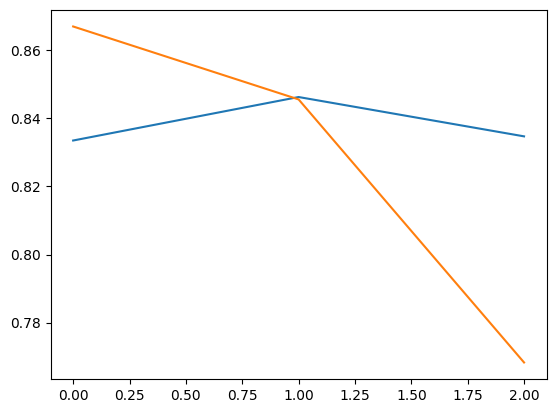

<Figure size 1000x500 with 0 Axes>

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.figure(figsize=(10, 5))
plt.plot(accuracy, label='Train')
plt.plot(val_accuracy, label='Validation')
plt.title('Model Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0, 1)

plt.legend(loc='lower right', fontsize=12)
plt.show()

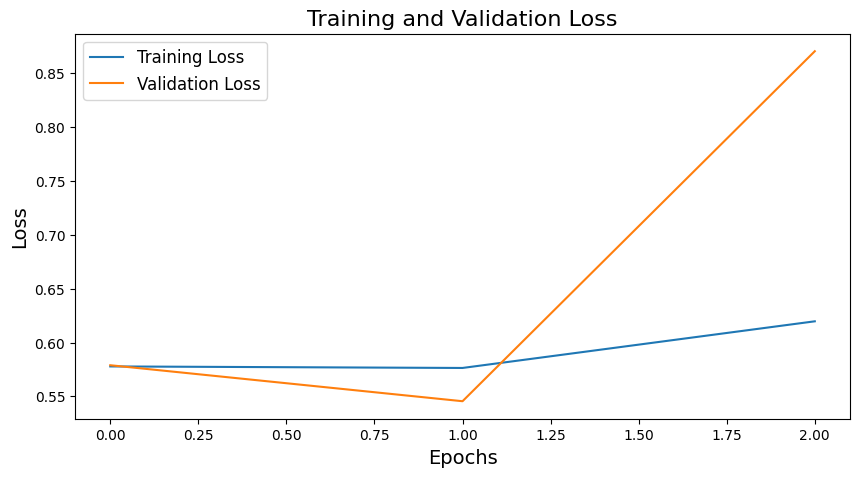

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']

# Створюємо графік
plt.figure(figsize=(10, 5))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)

plt.show()

In [18]:
class_folds = {v: k for k, v in train_generator.class_indices.items()}
class_names = list(train_generator.class_indices.keys())

In [19]:
test_generator.reset()
pred = model_Dense_L.predict(test_generator)
predicted_class_indices = np.argmax(pred, axis=1)
true_class_indices = test_generator.classes
print(classification_report(true_class_indices, predicted_class_indices, target_names=class_names))

170/170 [==============================] - 24s 142ms/step
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.75      0.62      0.68        63
                                 Apple___Black_rot       0.90      0.58      0.71        62
                          Apple___Cedar_apple_rust       0.52      0.52      0.52        27
                                   Apple___healthy       0.87      0.97      0.92       164
                               Blueberry___healthy       1.00      0.99      0.99       150
          Cherry_(including_sour)___Powdery_mildew       0.98      0.81      0.89       105
                 Cherry_(including_sour)___healthy       0.91      0.96      0.94        85
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.43      0.55      0.48        51
                       Corn_(maize)___Common_rust_       0.93      1.00      0.96       119
               Corn_(

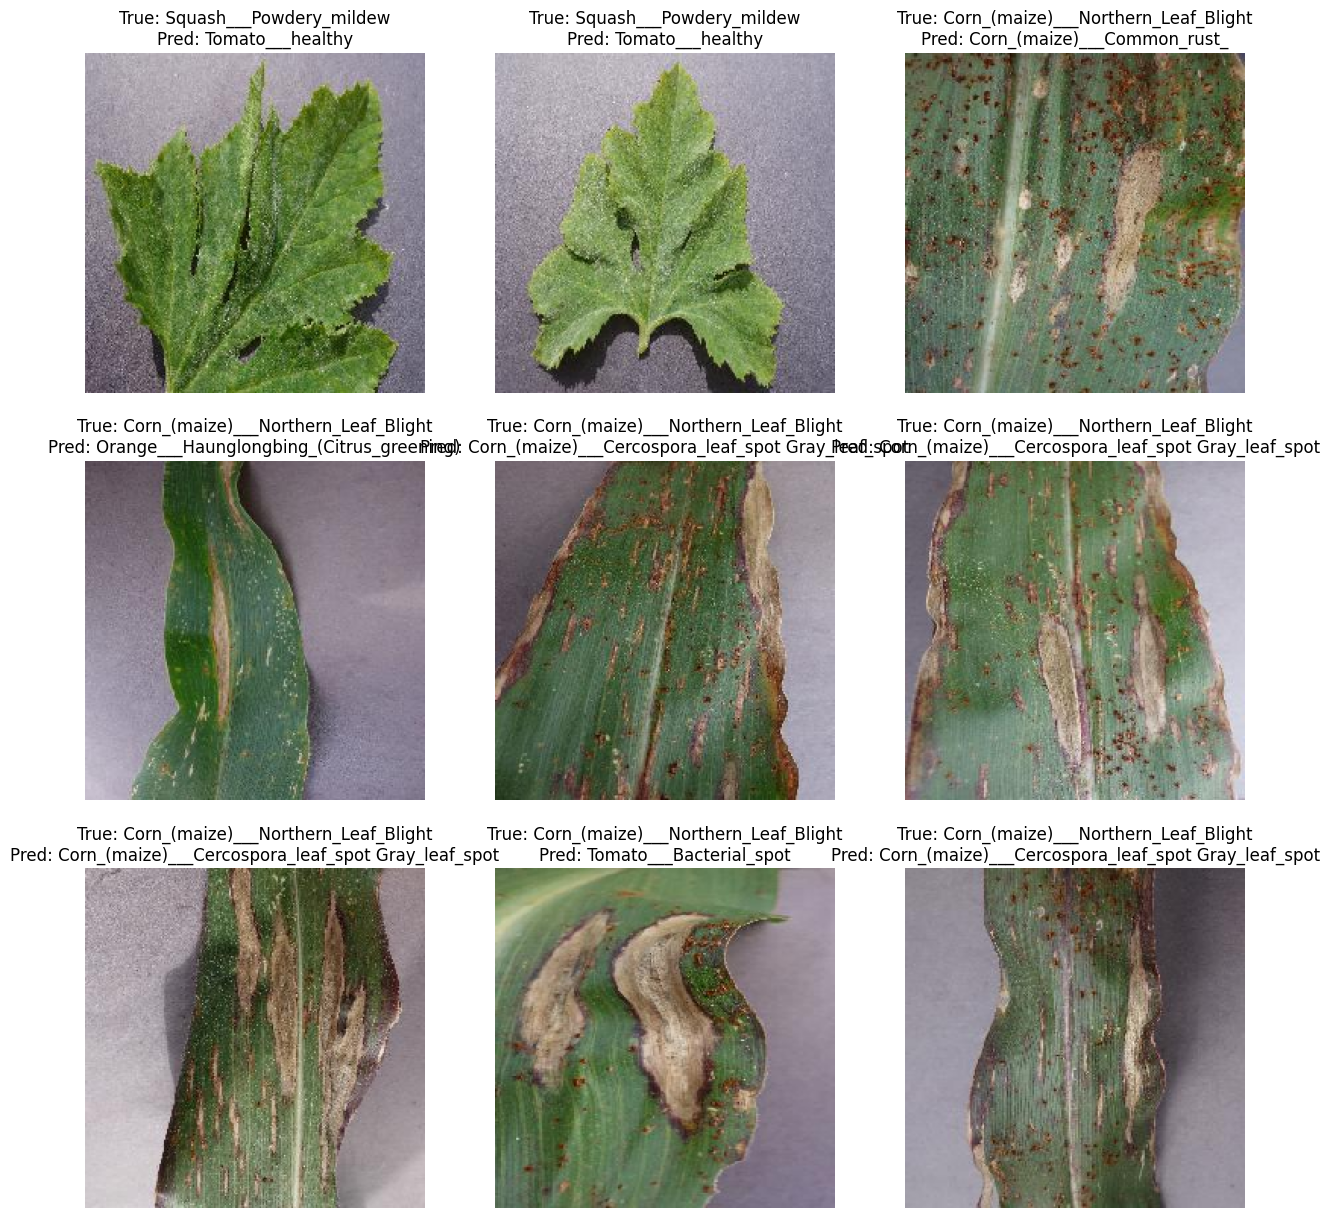

In [20]:
plt.figure(figsize=(15, 15))
for i, row in enumerate(misclassified_images.head(9).itertuples()):
    img_path = test_df.iloc[row.Index]['Filepaths']
    img = keras_image.load_img(img_path, target_size=(224, 224))
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    true_label = class_folds[row._1]  # Use 'True Label' as defined in error_df
    pred_label = class_folds[row._2]  # Use 'Predicted Label' as defined in error_df
    plt.title(f'True: {true_label}\nPred: {pred_label}')
    plt.axis('off')
plt.show()

# DenseNet + AdamW

In [39]:
INPUT_SHAPE = (224, 224, 3)
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

for layer in base_model.layers[:-30]:
    layer.trainable = False

inputs = Input(shape=INPUT_SHAPE)
densenet_output = base_model(inputs)

x = GlobalAveragePooling2D(name="Global_average_pooling_layer")(densenet_output)
x = Dense(256, activation="relu", kernel_initializer=tf.keras.initializers.HeNormal(), name="Dense_layer_1")(x)
x = Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.HeNormal(), name="Dense_layer_2")(x)
x = Dense(64, activation="relu", kernel_initializer=tf.keras.initializers.HeNormal(), name="Dense_layer_3")(x)
x = Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.HeNormal(), name="Dense_layer_4")(x)
outputs = Dense(38, activation="softmax", name="Dense_layer_5")(x)

model_Dense_AW = Model(inputs=inputs, outputs=outputs)

In [42]:
optimizer = AdamW(learning_rate=schedule, weight_decay=1e-4)

model_Dense_AW.compile(optimizer=optimizer,
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

model_Dense_AW.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 Global_average_pooling_lay  (None, 1920)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 Dense_layer_1 (Dense)       (None, 256)               491776    
                                                                 
 Dense_layer_2 (Dense)       (None, 128)               32896     
                                                                 
 Dense_layer_3 (Dense)       (None, 64)                8256

In [43]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=3,
                               verbose=1,
                               restore_best_weights=True,
                               mode='max',
                               min_delta=0.01,
                               baseline=0.95)

model_checkpoint = ModelCheckpoint('DenseNet+AW.h5',
                                   monitor='val_accuracy',
                                   save_best_only=True,
                                   mode='max',
                                   verbose=1)

In [44]:
%%time
history = model_Dense_AW.fit(
    train_generator,
    validation_data=valid_generator,
    epochs = 5,
    callbacks = [early_stopping, model_checkpoint]
)

Epoch 1/5
1358/1358 [==============================] - ETA: 0s - loss: 0.4765 - accuracy: 0.8627
Epoch 1: val_accuracy improved from -inf to 0.95878, saving model to DenseNet+AW.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1358/1358 [==============================] - 653s 468ms/step - loss: 0.4765 - accuracy: 0.8627 - val_loss: 0.1307 - val_accuracy: 0.9588
Epoch 2/5
1358/1358 [==============================] - ETA: 0s - loss: 0.1436 - accuracy: 0.9548
Epoch 2: val_accuracy did not improve from 0.95878
1358/1358 [==============================] - 635s 468ms/step - loss: 0.1436 - accuracy: 0.9548 - val_loss: 0.1458 - val_accuracy: 0.9582
Epoch 3/5
1358/1358 [==============================] - ETA: 0s - loss: 0.1120 - accuracy: 0.9651Restoring model weights from the end of the best epoch: 1.

Epoch 3: val_accuracy improved from 0.95878 to 0.96373, saving model to DenseNet+AW.h5
1358/1358 [==============================] - 638s 469ms/step - loss: 0.1120 - accuracy: 0.9651 - val_loss: 0.1131 - val_accuracy: 0.9637
Epoch 3: early stopping
CPU times: user 34min, sys: 1min 3s, total: 35min 3s
Wall time: 32min 5s


In [45]:
test_loss, test_accuracy = model_Dense_AW.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)

170/170 [==============================] - 25s 144ms/step - loss: 0.1360 - accuracy: 0.9546
Test Accuracy: 0.9545873999595642


NameError: name 'accuracy' is not defined

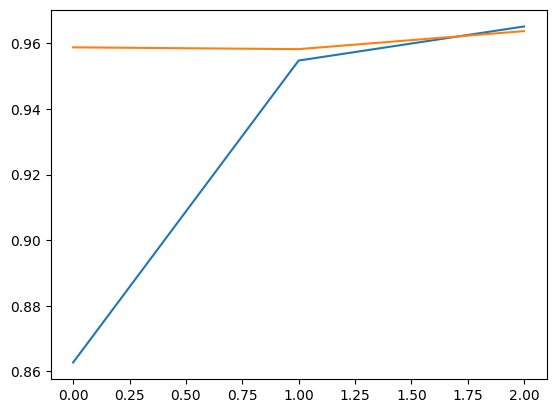

<Figure size 1000x500 with 0 Axes>

In [46]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.figure(figsize=(10, 5))
plt.plot(accuracy, label='Train')
plt.plot(val_accuracy, label='Validation')
plt.title('Model Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0, 1)

plt.legend(loc='lower right', fontsize=12)
plt.show()

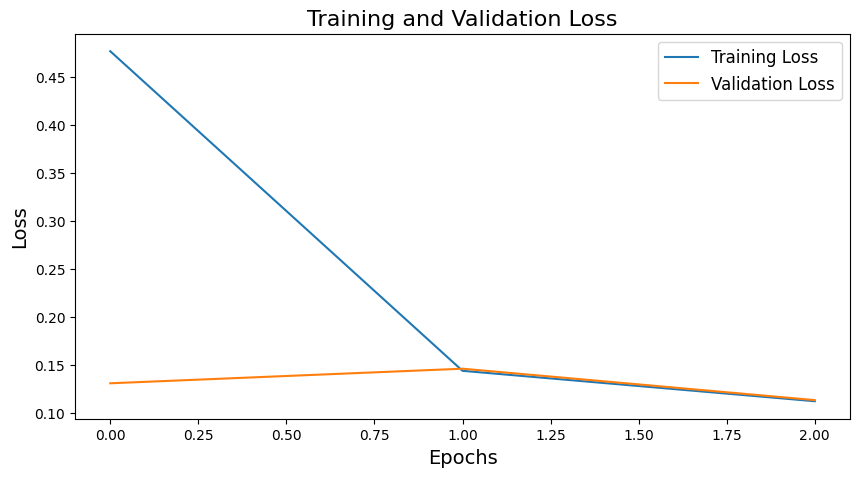

In [47]:
loss = history.history['loss']
val_loss = history.history['val_loss']

# Створюємо графік
plt.figure(figsize=(10, 5))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)

plt.show()

In [48]:
test_generator.reset()
pred = model_Dense_AW.predict(test_generator)
predicted_class_indices = np.argmax(pred, axis=1)
true_class_indices = test_generator.classes
print(classification_report(true_class_indices, predicted_class_indices, target_names=class_names))

170/170 [==============================] - 27s 141ms/step
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.98      0.90      0.94        63
                                 Apple___Black_rot       0.95      1.00      0.98        62
                          Apple___Cedar_apple_rust       0.96      0.96      0.96        27
                                   Apple___healthy       0.98      0.90      0.94       164
                               Blueberry___healthy       1.00      0.99      1.00       150
          Cherry_(including_sour)___Powdery_mildew       1.00      0.98      0.99       105
                 Cherry_(including_sour)___healthy       0.99      0.95      0.97        85
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.95      0.73      0.82        51
                       Corn_(maize)___Common_rust_       0.99      1.00      1.00       119
               Corn_(

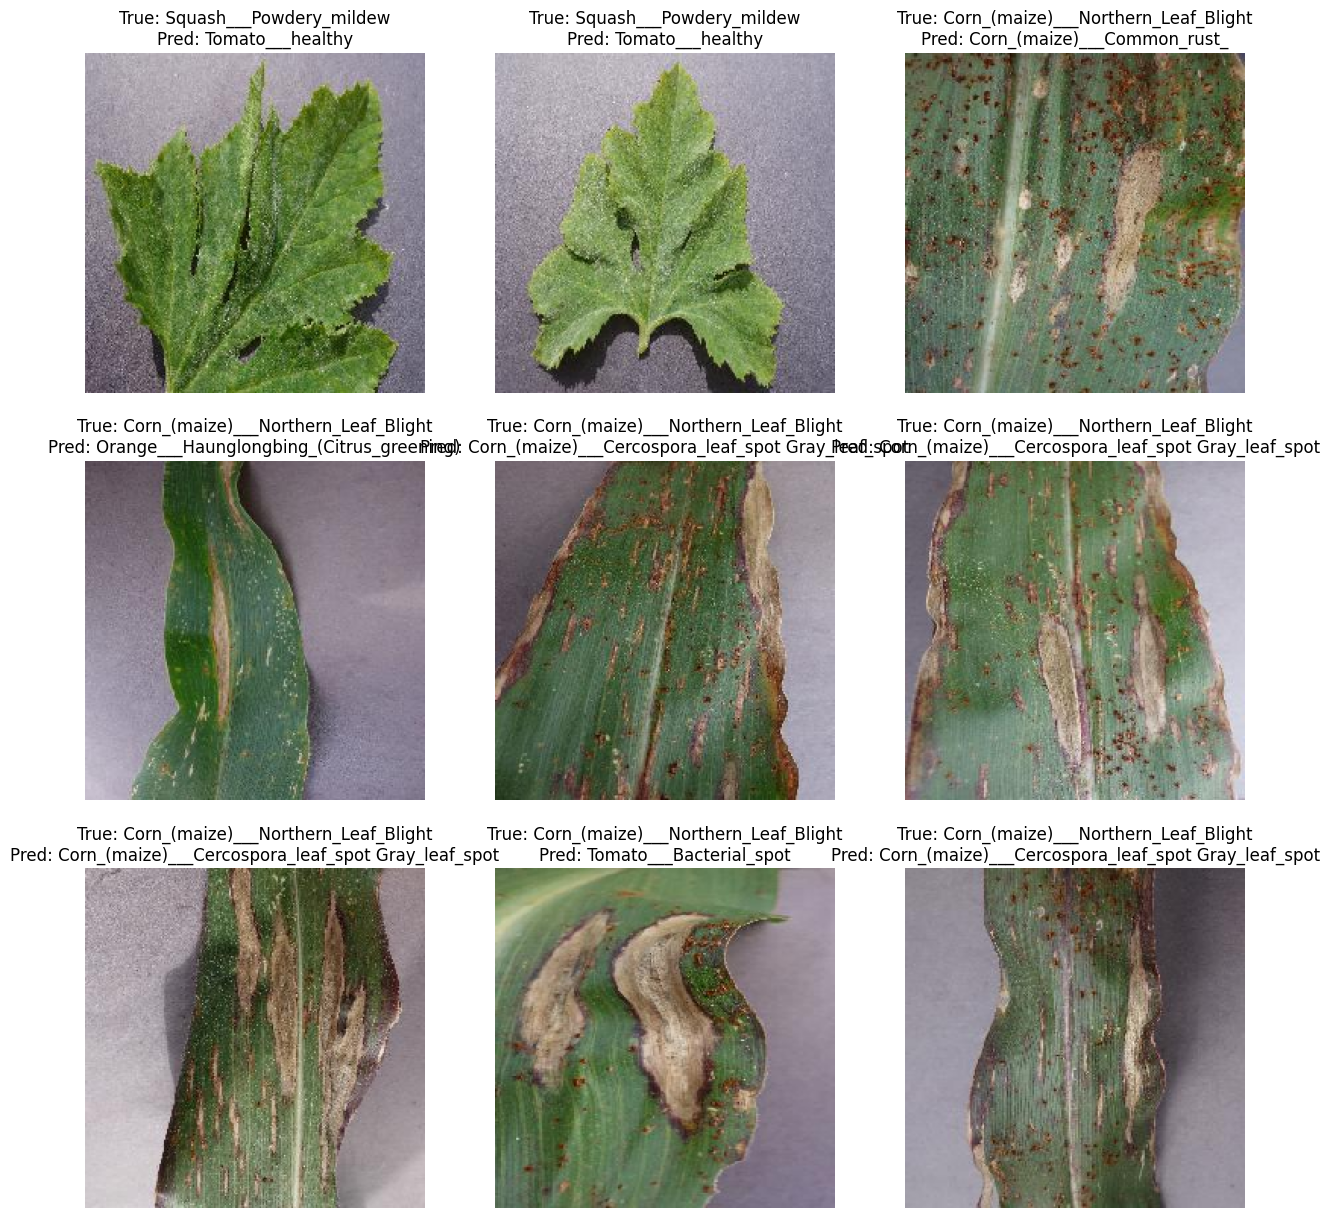

In [49]:
plt.figure(figsize=(15, 15))
for i, row in enumerate(misclassified_images.head(9).itertuples()):
    img_path = test_df.iloc[row.Index]['Filepaths']
    img = keras_image.load_img(img_path, target_size=(224, 224))
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    true_label = class_folds[row._1]  # Use 'True Label' as defined in error_df
    pred_label = class_folds[row._2]  # Use 'Predicted Label' as defined in error_df
    plt.title(f'True: {true_label}\nPred: {pred_label}')
    plt.axis('off')
plt.show()